In [2]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, validation_curve,cross_val_score,KFold
from sklearn.linear_model import Lasso,LassoCV,LinearRegression,RidgeCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt


sys.path.append('..')
from ModelFunctions import ols_model,train_and_test_linear,scale_test_and_train_Lasso,scale_test_and_train_ridge,cross_val_linear

## Explore the data

In [3]:
oscars_df = pd.read_csv('oscar_movies_data_2.csv')

In [4]:
oscars_df.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
oscars_df.head()

IMDBId                 movie title language    country  runtime (mins)  \
0  tt0091763                     Platoon  English        USA             120   
1  tt0082979                        Reds  English        USA             195   
2  tt0084434  An Officer and a Gentleman  English        USA             124   
3  tt0119360                    In & Out  English        USA              90   
4  tt0292542            Son of the Bride  Spanish  Argentina             123   

  mpaarating  metacritic score        budget     distributionCompany  \
0          R              92.0  6.000000e+06          Orion Pictures   
1         PG              76.0  3.200000e+07      Paramount Pictures   
2          R              75.0  7.500000e+06      Paramount Pictures   
3      PG-13              70.0  3.500000e+07      Paramount Pictures   
4          R              68.0  1.193676e+07  Sony Pictures Classics   

                              Awards  ...  Writer_Aaron Sorkin  \
0    Best Actor in a Supporting Role  ...                  NaN   
1       Best Actor in a Leading Role  ...                  NaN   
2    Best Actor in a Supporting Role  ...                  NaN   
3  Best Actress in a Supporting Role  ...                  NaN   
4         Best Foreign Language Film  ...                  NaN   

  Writer_Joel Coen Writer_John Lasseter Writer_John Logan  \
0              NaN                  NaN               NaN   
1              NaN                  NaN               NaN   
2              NaN                  NaN               NaN   
3              NaN                  NaN               NaN   
4              NaN                  NaN               NaN   

  Writer_Lawrence Kasdan Writer_Lee Hall Writer_Paul Thomas Anderson  \
0                    NaN             NaN                         NaN   
1                    NaN             NaN                         NaN   
2                    NaN             NaN                         NaN   
3                    NaN             NaN                         NaN   
4                    NaN             NaN                         NaN   

  Writer_Pedro Almodóvar Writer_Quentin Tarantino Writer_Woody Allen  
0                    NaN                      NaN                NaN  
1                    NaN                      NaN                NaN  
2                    NaN                      NaN                NaN  
3                    NaN                      NaN                NaN  
4                    NaN                      NaN                NaN  

[5 rows x 110 columns]

In [6]:
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(oscars_df.select_dtypes(include=numerics).columns)
oscars_data = oscars_df[numerical_vars]
oscars_data.shape

(1136, 90)

In [7]:
#Fill the budget with the mean of the other budgets
oscars_data['budget'].fillna(oscars_data['budget'].mean(),inplace=True)
oscars_data.fillna(0,inplace=True)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [8]:
oscars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 90 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   runtime (mins)                            1136 non-null   int64  
 1   metacritic score                          1136 non-null   float64
 2   budget                                    1136 non-null   float64
 3   Total_Noms                                1136 non-null   int64  
 4   Award_Year                                1136 non-null   float64
 5   Awards_Best Actor in a Leading Role       1136 non-null   float64
 6   Awards_Best Actor in a Supporting Role    1136 non-null   float64
 7   Awards_Best Actress in a Leading Role     1136 non-null   float64
 8   Awards_Best Art Direction-Set Decoration  1136 non-null   float64
 9   Awards_Best Cinematography                1136 non-null   float64
 10  Awards_Best Director                

In [9]:
oscars_data.corr()

runtime (mins)  metacritic score    budget  \
runtime (mins)                     1.000000         -0.019315  0.209810   
metacritic score                  -0.019315          1.000000 -0.154606   
budget                             0.209810         -0.154606  1.000000   
Total_Noms                         0.355896          0.327954  0.046763   
Award_Year                         0.062201         -0.005633  0.034585   
...                                     ...               ...       ...   
Writer_Lee Hall                    0.005363         -0.016820 -0.011952   
Writer_Paul Thomas Anderson        0.102951          0.069278 -0.019045   
Writer_Pedro Almodóvar            -0.039734          0.067315 -0.044876   
Writer_Quentin Tarantino           0.130759          0.023753  0.016457   
Writer_Woody Allen                -0.111100          0.017157 -0.057594   

                             Total_Noms  Award_Year  \
runtime (mins)                 0.355896    0.062201   
metacritic score               0.327954   -0.005633   
budget                         0.046763    0.034585   
Total_Noms                     1.000000    0.071295   
Award_Year                     0.071295    1.000000   
...                                 ...         ...   
Writer_Lee Hall                0.001532    0.009169   
Writer_Paul Thomas Anderson    0.041133    0.008715   
Writer_Pedro Almodóvar        -0.037707    0.007546   
Writer_Quentin Tarantino       0.073881    0.009788   
Writer_Woody Allen            -0.016481    0.007576   

                             Awards_Best Actor in a Leading Role  \
runtime (mins)                                          0.132043   
metacritic score                                        0.080313   
budget                                                 -0.100454   
Total_Noms                                              0.237237   
Award_Year                                              0.017762   
...                                                          ...   
Writer_Lee Hall                                        -0.019169   
Writer_Paul Thomas Anderson                            -0.021441   
Writer_Pedro Almodóvar                                 -0.021441   
Writer_Quentin Tarantino                                0.018081   
Writer_Woody Allen                                     -0.003841   

                             Awards_Best Actor in a Supporting Role  \
runtime (mins)                                             0.078923   
metacritic score                                           0.025476   
budget                                                    -0.087471   
Total_Noms                                                 0.119842   
Award_Year                                                 0.014441   
...                                                             ...   
Writer_Lee Hall                                           -0.016029   
Writer_Paul Thomas Anderson                                0.087874   
Writer_Pedro Almodóvar                                    -0.017929   
Writer_Quentin Tarantino                                   0.028665   
Writer_Woody Allen                                         0.040646   

                             Awards_Best Actress in a Leading Role  \
runtime (mins)                                            0.005028   
metacritic score                                         -0.013267   
budget                                                   -0.070021   
Total_Noms                                                0.046157   
Award_Year                                                0.015956   
...                                                            ...   
Writer_Lee Hall                                          -0.015116   
Writer_Paul Thomas Anderson                              -0.016908   
Writer_Pedro Almodóvar                                   -0.016908   
Writer_Quentin Tarantino                                 -0.018530   
Writer_Woody Allen         

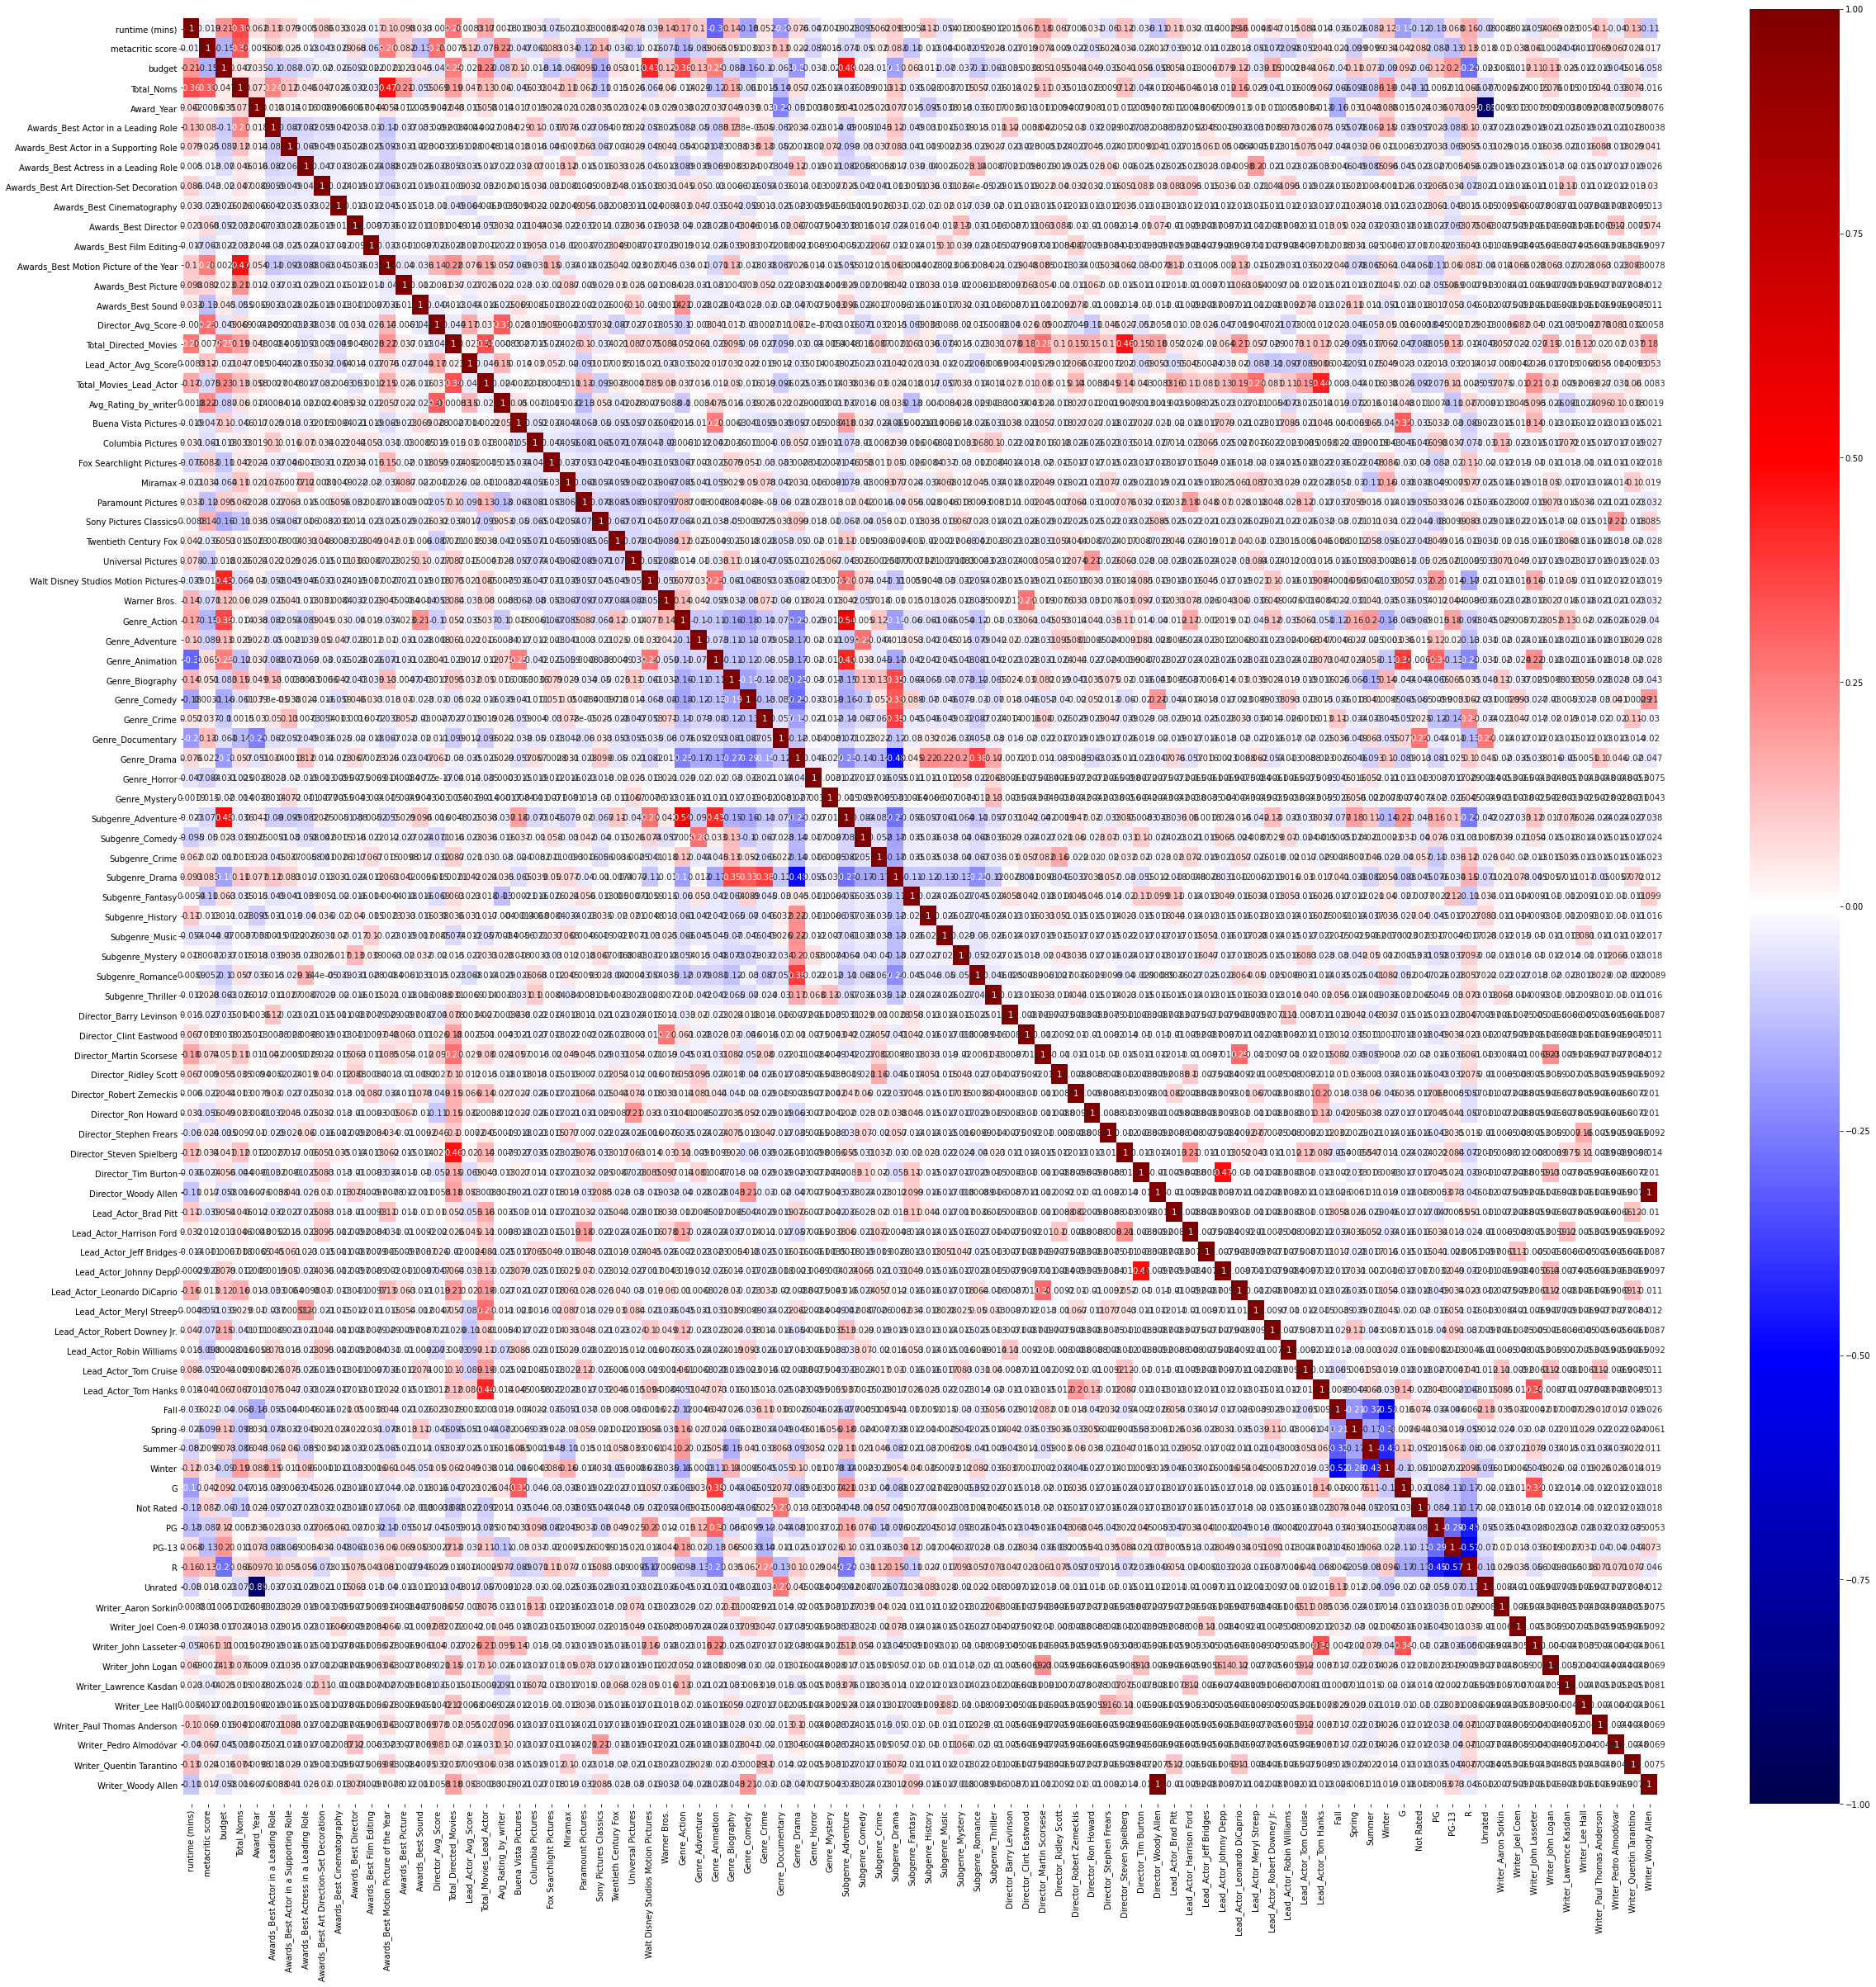

In [9]:
plt.figure(figsize=(40,40))
sns.heatmap(oscars_data.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

plt.gca().set_ylim(len(oscars_data.corr())+0.5, -0.5);

## Run a baseline model on the dataframe with no engineered features

In [10]:
baseline_df = oscars_data.drop(columns=['Total_Directed_Movies',\
                                        'Lead_Actor_Avg_Score','Total_Movies_Lead_Actor',\
                                        'Director_Avg_Score','Avg_Rating_by_writer','Award_Year','Total_Noms'])

In [11]:
baseline_df.corr()

runtime (mins)  metacritic score  \
runtime (mins)                                1.000000         -0.019315   
metacritic score                             -0.019315          1.000000   
budget                                        0.209810         -0.154606   
Awards_Best Actor in a Leading Role           0.132043          0.080313   
Awards_Best Actor in a Supporting Role        0.078923          0.025476   
...                                                ...               ...   
Writer_Lee Hall                               0.005363         -0.016820   
Writer_Paul Thomas Anderson                   0.102951          0.069278   
Writer_Pedro Almodóvar                       -0.039734          0.067315   
Writer_Quentin Tarantino                      0.130759          0.023753   
Writer_Woody Allen                           -0.111100          0.017157   

                                          budget  \
runtime (mins)                          0.209810   
metacritic score                       -0.154606   
budget                                  1.000000   
Awards_Best Actor in a Leading Role    -0.100454   
Awards_Best Actor in a Supporting Role -0.087471   
...                                          ...   
Writer_Lee Hall                        -0.011952   
Writer_Paul Thomas Anderson            -0.019045   
Writer_Pedro Almodóvar                 -0.044876   
Writer_Quentin Tarantino                0.016457   
Writer_Woody Allen                     -0.057594   

                                        Awards_Best Actor in a Leading Role  \
runtime (mins)                                                     0.132043   
metacritic score                                                   0.080313   
budget                                                            -0.100454   
Awards_Best Actor in a Leading Role                                1.000000   
Awards_Best Actor in a Supporting Role                            -0.086952   
...                                                                     ...   
Writer_Lee Hall                                                   -0.019169   
Writer_Paul Thomas Anderson                                       -0.021441   
Writer_Pedro Almodóvar                                            -0.021441   
Writer_Quentin Tarantino                                           0.018081   
Writer_Woody Allen                                                -0.003841   

                                        Awards_Best Actor in a Supporting Role  \
runtime (mins)                                                        0.078923   
metacritic score                                                      0.025476   
budget                                                               -0.087471   
Awards_Best Actor in a Leading Role                                  -0.086952   
Awards_Best Actor in a Supporting Role                                1.000000   
...                                                                        ...   
Writer_Lee Hall                                                      -0.016029   
Writer_Paul Thomas Anderson                                           0.087874   
Writer_Pedro Almodóvar                                               -0.017929   
Writer_Quentin Tarantino                                              0.028665   
Writer_Woody Allen                                                    0.040646   

                                        Awards_Best Actress in a Leading Role  \
runtime (mins)                                                       0.005028   
metacritic score                                                    -0.013267   
budget                                                              -0.070021   
Awards_Best Actor in a Leading Role                                 -0.082002   
Awards_Best Actor in a Supporting Role                              -0.068571   
...                                                                       ...   
W

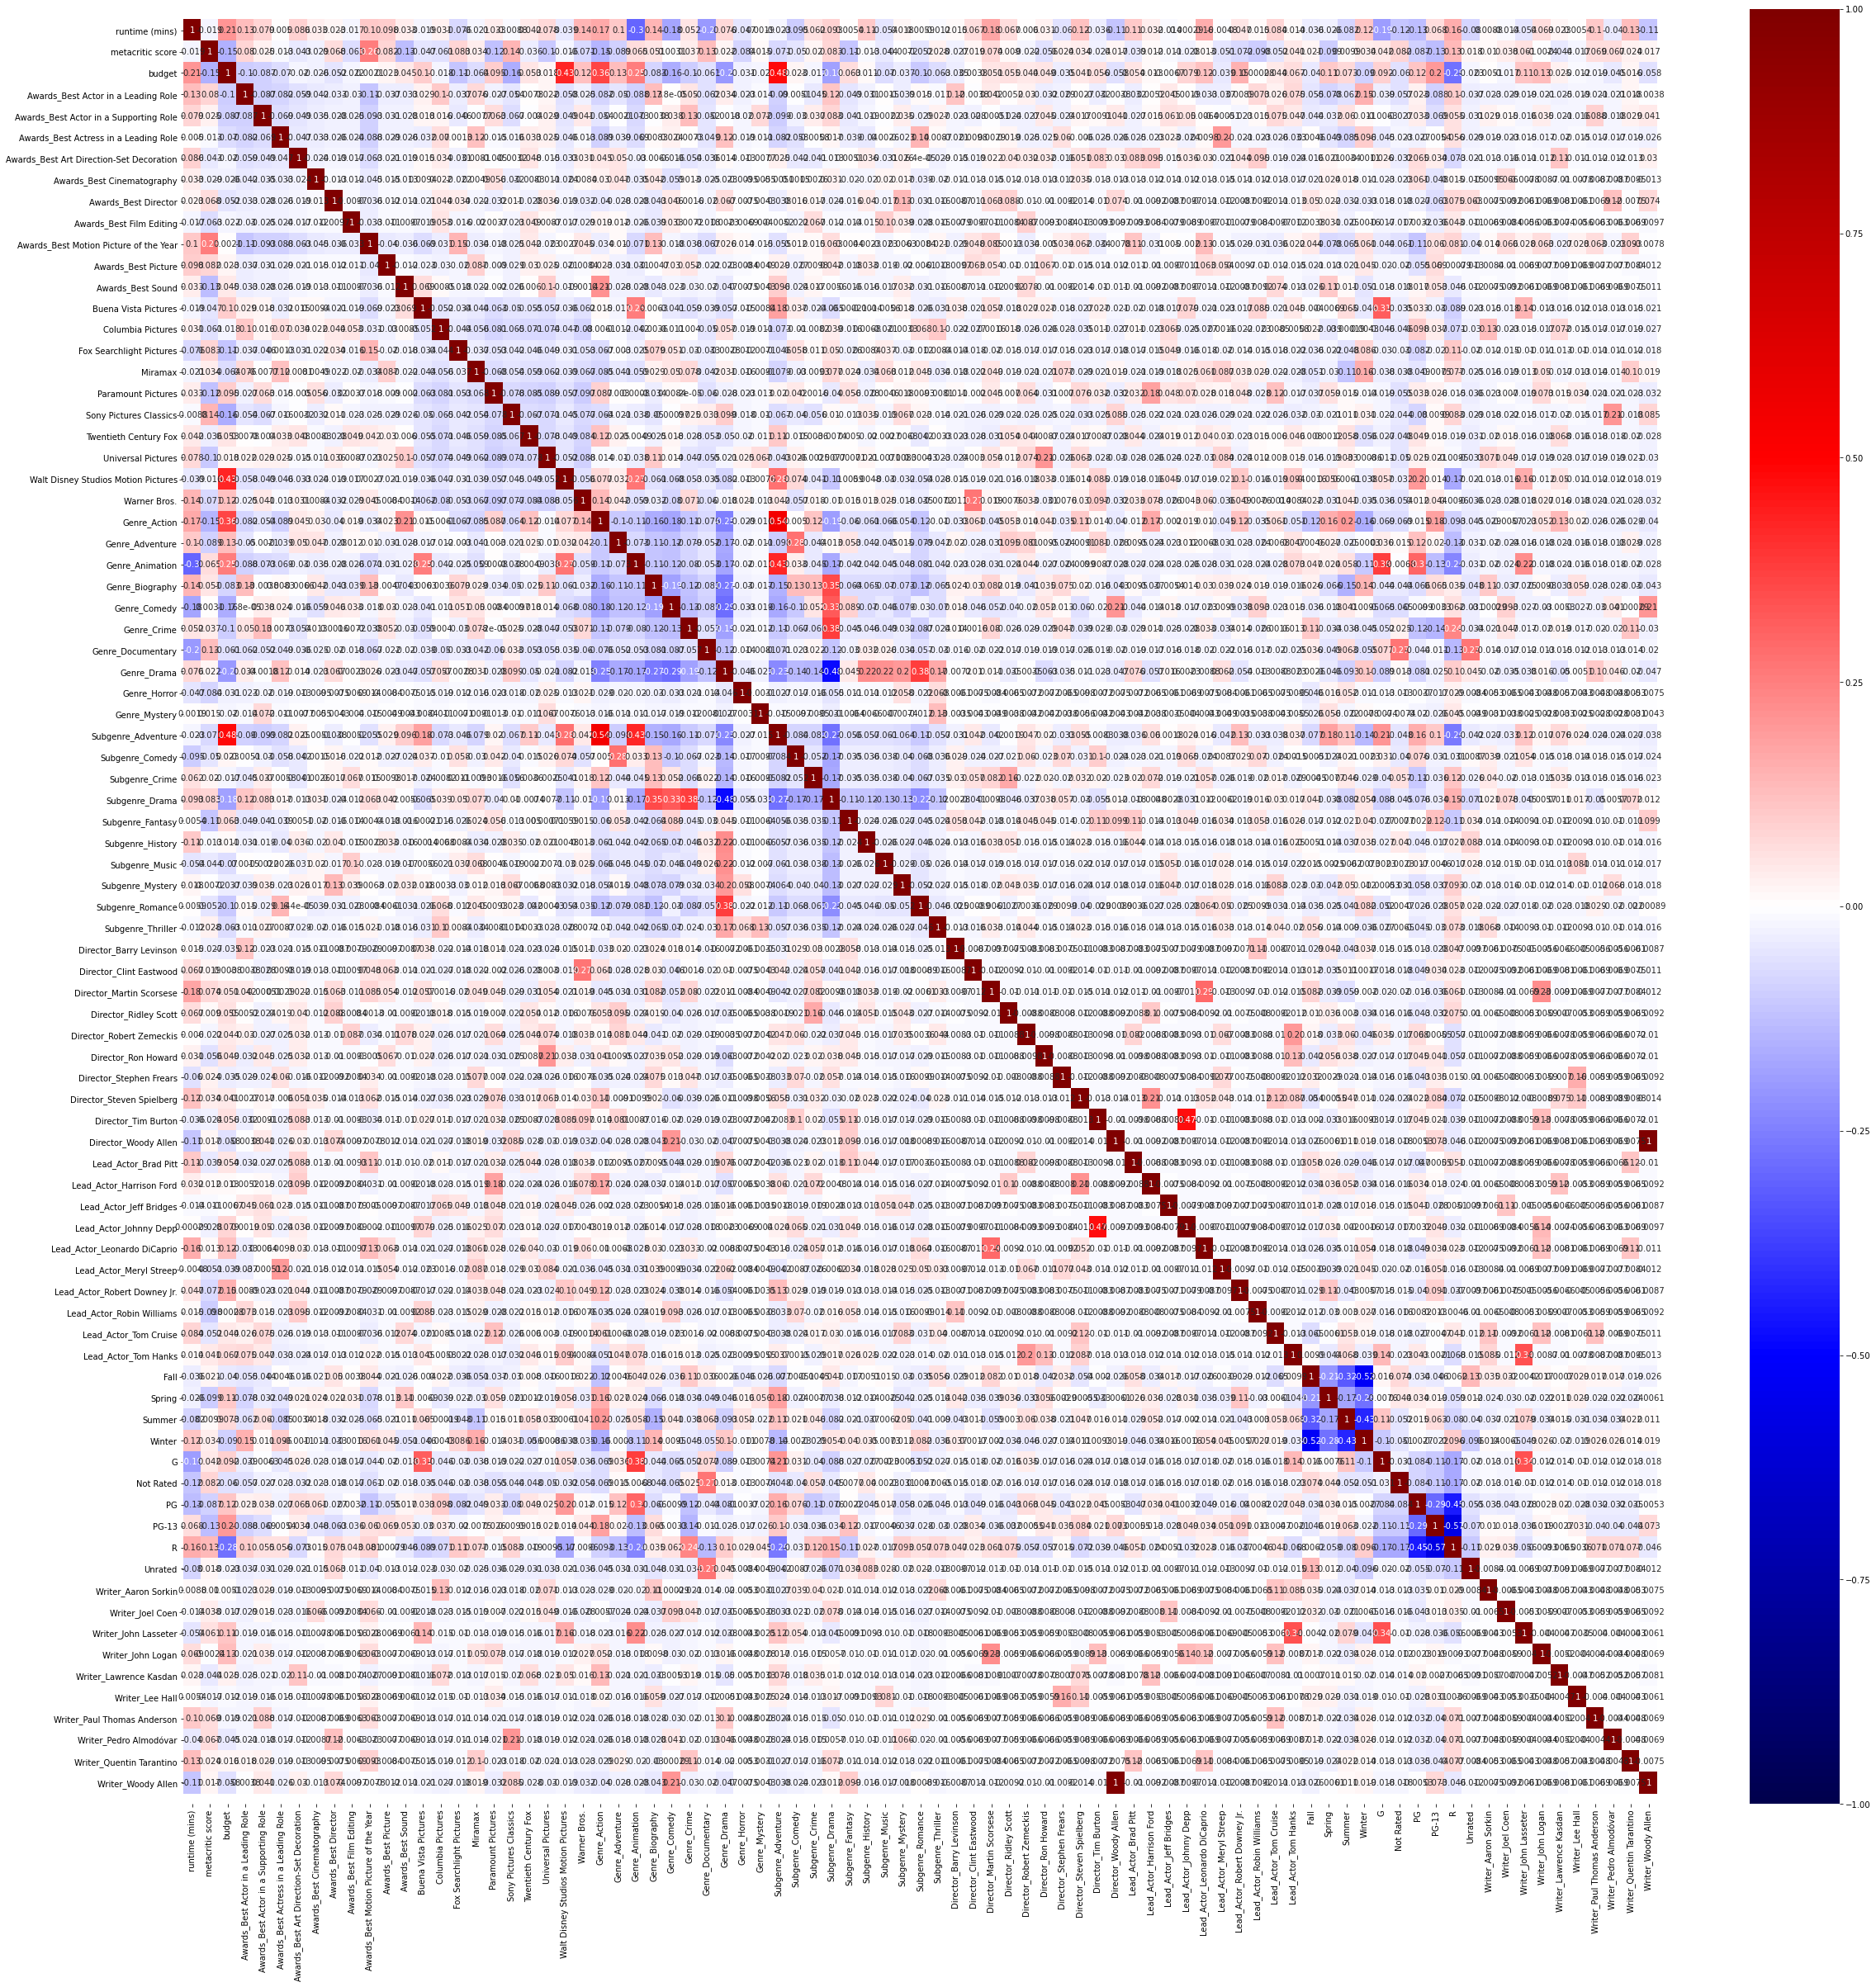

In [12]:
plt.figure(figsize=(40,40))
sns.heatmap(baseline_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

plt.gca().set_ylim(len(baseline_df.corr())+0.5, -0.5);

In [13]:
X = baseline_df.drop(columns='metacritic score')
y = baseline_df['metacritic score']

In [14]:
train_and_test_linear(X,y)

Linear Regression val R^2: 0.328
Linear Regression val RME: 13.353


In [15]:
ols_model(X,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       metacritic score   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     4.730
Date:                Sun, 11 Oct 2020   Prob (F-statistic):           4.18e-31
Time:                        23:20:50   Log-Likelihood:                -3484.2
No. Observations:                 908   AIC:                             7128.
Df Residuals:                     828   BIC:                             7513.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.9559      0.390    184.439      0.000      71.190      72.722
x1             0.5375      0.526      1.022      0.307      -0.495       1.570
x2            -0.3214      0.565     -0.569      0.569      -1.430       0.787
x3             2.2985      0.445      5.167      0.000       1.425       3.172
x4             1.5145      0.433      3.497      0.000       0.664       2.365
x5             1.0470      0.432      2.423      0.016       0.199       1.895
x6             0.4362      0.419      1.040      0.299      -0.387       1.259
x7             0.8513      0.405      2.101      0.036       0.056       1.647
x8             0.9264      0.420      2.208      0.028       0.103       1.750
x9            -0.5854      0.406     -1.441      0.150      -1.383       0.212
x10            3.9081      0.439      8.896      0.000       3.046       4.770
x11            1.6548      0.410      4.033      0.000       0.849       2.460
x12           -1.1358      0.412     -2.754      0.006      -1.945      -0.326
x13           -1.2758      0.452     -2.823      0.005      -2.163      -0.389
x14           -1.2331      0.446     -2.764      0.006      -2.109      -0.357
x15            0.1744      0.413      0.422      0.673      -0.637       0.986
x16           -0.1121      0.430     -0.261      0.794      -0.956       0.732
x17           -1.4646      0.449     -3.264      0.001      -2.345      -0.584
x18            1.4467      0.426      3.400      0.001       0.612       2.282
x19           -0.6915      0.432     -1.601      0.110      -1.539       0.157
x20           -1.8052      0.444     -4.065      0.000      -2.677      -0.934
x21           -0.3632      0.478     -0.761      0.447      -1.301       0.574
x22           -1.1378      0.479     -2.375      0.018      -2.078      -0.198
x23            0.7683      2.249      0.342      0.733      -3.646       5.183
x24            0.0049      1.630      0.003      0.998      -3.195       3.204
x25            3.0624      1.735      1.765      0.078      -0.343       6.468
x26            1.2693      2.369      0.536      0.592      -3.381       5.919
x27            1.4205      2.446      0.581      0.561      -3.380       6.221
x28            0.3110      1.760      0.177      0.860      -3.143       3.765
x29            2.2534      1.294      1.742      0.082      -0.286       4.792
x30            1.6440      2.915      0.564      0.573      -4.077       7.365
x31           -0.1875      0.579     -0.324      0.746      -1.324       0.949
x32            0.4613      0.500      0.922      0.357      -0.521       1.443
x33            0.1752      0.697      0.251      0.802      -1.193       1.543
x34           -0.2021      0.527     -0.384      0.701      -1.236       0.832
x35            0.2199      0.523      0.421      0.674      -0.806       1.245
x3

## High condition score add in engineered features

In [16]:
oscars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 90 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   runtime (mins)                            1136 non-null   int64  
 1   metacritic score                          1136 non-null   float64
 2   budget                                    1136 non-null   float64
 3   Total_Noms                                1136 non-null   int64  
 4   Award_Year                                1136 non-null   float64
 5   Awards_Best Actor in a Leading Role       1136 non-null   float64
 6   Awards_Best Actor in a Supporting Role    1136 non-null   float64
 7   Awards_Best Actress in a Leading Role     1136 non-null   float64
 8   Awards_Best Art Direction-Set Decoration  1136 non-null   float64
 9   Awards_Best Cinematography                1136 non-null   float64
 10  Awards_Best Director                

In [17]:
X= oscars_data.drop(columns=['metacritic score'])
y= oscars_data['metacritic score']

In [18]:
train_and_test_linear(X,y)

Linear Regression val R^2: 0.428
Linear Regression val RME: 12.919


In [19]:
ols_model(X,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       metacritic score   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     6.648
Date:                Sun, 11 Oct 2020   Prob (F-statistic):           1.41e-51
Time:                        23:20:51   Log-Likelihood:                -3413.3
No. Observations:                 908   AIC:                             7001.
Df Residuals:                     821   BIC:                             7419.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.9559      0.362    198.561      0.000      71.245      72.667
x1            -0.6560      0.507     -1.293      0.196      -1.652       0.340
x2            -0.5218      0.554     -0.942      0.347      -1.610       0.566
x3             4.9405      0.546      9.047      0.000       3.869       6.012
x4             0.0743      0.721      0.103      0.918      -1.342       1.490
x5             0.7420      0.449      1.652      0.099      -0.140       1.624
x6             0.2775      0.423      0.656      0.512      -0.553       1.108
x7             0.3535      0.411      0.860      0.390      -0.453       1.160
x8            -0.1353      0.396     -0.342      0.733      -0.913       0.642
x9             0.6945      0.379      1.835      0.067      -0.049       1.438
x10            0.7941      0.396      2.007      0.045       0.017       1.571
x11           -0.5250      0.378     -1.389      0.165      -1.267       0.217
x12            0.9573      0.512      1.870      0.062      -0.048       1.962
x13            0.3747      0.406      0.923      0.356      -0.422       1.172
x14           -0.8823      0.384     -2.295      0.022      -1.637      -0.128
x15            2.2321      0.408      5.468      0.000       1.431       3.033
x16            0.0839      0.648      0.130      0.897      -1.187       1.355
x17            0.1180      0.391      0.302      0.763      -0.649       0.885
x18           -1.2541      0.559     -2.243      0.025      -2.352      -0.156
x19            1.0837      0.408      2.653      0.008       0.282       1.885
x20           -1.1485      0.422     -2.723      0.007      -1.976      -0.321
x21           -1.1544      0.416     -2.776      0.006      -1.971      -0.338
x22            0.0550      0.386      0.143      0.887      -0.702       0.812
x23           -0.3863      0.401     -0.964      0.335      -1.173       0.400
x24           -1.2706      0.423     -3.001      0.003      -2.102      -0.439
x25            1.5634      0.397      3.940      0.000       0.784       2.342
x26           -0.2619      0.403     -0.649      0.516      -1.054       0.530
x27           -1.5816      0.413     -3.829      0.000      -2.392      -0.771
x28            0.1857      0.446      0.416      0.678      -0.691       1.062
x29           -0.9488      0.448     -2.116      0.035      -1.829      -0.069
x30            1.5295      2.096      0.730      0.466      -2.585       5.644
x31            0.2448      1.518      0.161      0.872      -2.735       3.224
x32            3.2183      1.614      1.993      0.047       0.049       6.387
x33            2.0328      2.207      0.921      0.357      -2.299       6.364
x34            2.2806      2.280      1.000      0.317      -2.194       6.755
x35            1.0727      1.640      0.654      0.513      -2.147       4.292
x3

### Perform a Lasso Regression on the model due to high P-values and high condition number

In [20]:
lasso = scale_test_and_train_Lasso(X,y)

Lasso Regression val R^2: 0.245
Lasso Regression val RME: 11.685


In [21]:
list(zip(oscars_data.drop(columns='metacritic score'),lasso))

[('runtime (mins)', -0.3980981099775679),
 ('budget', -1.0730750679640133),
 ('Total_Noms', 4.5938671450708535),
 ('Award_Year', 0.0643076499698641),
 ('Awards_Best Actor in a Leading Role', 0.08801489372718738),
 ('Awards_Best Actor in a Supporting Role', 0.0),
 ('Awards_Best Actress in a Leading Role', -0.0),
 ('Awards_Best Art Direction-Set Decoration', -0.08323100704158767),
 ('Awards_Best Cinematography', 0.0),
 ('Awards_Best Director', 0.6571844487482111),
 ('Awards_Best Film Editing', -0.4737793546798956),
 ('Awards_Best Motion Picture of the Year', 0.8642207191612156),
 ('Awards_Best Picture', 0.0),
 ('Awards_Best Sound', -0.5174996588735344),
 ('Director_Avg_Score', 1.9892246185735494),
 ('Total_Directed_Movies', 0.0),
 ('Lead_Actor_Avg_Score', -0.0),
 ('Total_Movies_Lead_Actor', -0.21883532253776025),
 ('Avg_Rating_by_writer', 0.9976213783906375),
 ('Buena Vista Pictures', -0.4608796548752648),
 ('Columbia Pictures', -0.6994333617730896),
 ('Fox Searchlight Pictures', 0.05682

In [22]:
smaller_df = oscars_data.drop(columns= ['Award_Year','Awards_Best Actor in a Supporting Role','Awards_Best Actress in a Leading Role',\
                                        'Awards_Best Art Direction-Set Decoration','Awards_Best Cinematography','Awards_Best Picture',\
                                       'Total_Directed_Movies','Lead_Actor_Avg_Score','Fox Searchlight Pictures','Miramax','Twentieth Century Fox',\
                                       'Genre_Biography','Genre_Comedy','Genre_Crime','Genre_Drama','Genre_Mystery','Subgenre_Adventure','Subgenre_Crime',\
                                       'Subgenre_Drama','Subgenre_History','Subgenre_Mystery','Director_Clint Eastwood','Director_Martin Scorsese',\
                                       'Director_Ridley Scott','Director_Robert Zemeckis','Director_Stephen Frears','Director_Steven Spielberg',\
                                       'Director_Woody Allen','Lead_Actor_Harrison Ford','Lead_Actor_Jeff Bridges','Lead_Actor_Johnny Depp','Lead_Actor_Meryl Streep',\
                                       'Lead_Actor_Robert Downey Jr.','Lead_Actor_Tom Cruise','Fall','Winter','G','R','Unrated','Writer_Aaron Sorkin',\
                                        'Writer_Joel Coen','Writer_John Logan','Writer_Lee Hall','Writer_Quentin Tarantino','Writer_Woody Allen'])
                                

In [23]:
smaller_df.corr()

runtime (mins)  metacritic score  \
runtime (mins)                                1.000000         -0.019315   
metacritic score                             -0.019315          1.000000   
budget                                        0.209810         -0.154606   
Total_Noms                                    0.355896          0.327954   
Awards_Best Actor in a Leading Role           0.132043          0.080313   
Awards_Best Director                          0.023140          0.068001   
Awards_Best Film Editing                     -0.017426         -0.063184   
Awards_Best Motion Picture of the Year        0.102197          0.255874   
Awards_Best Sound                             0.033011         -0.129017   
Director_Avg_Score                           -0.005964          0.274782   
Total_Movies_Lead_Actor                       0.165675         -0.075356   
Avg_Rating_by_writer                          0.001781          0.218782   
Buena Vista Pictures                         -0.018709         -0.047371   
Columbia Pictures                             0.030757         -0.061074   
Paramount Pictures                            0.032720         -0.117900   
Sony Pictures Classics                       -0.008826          0.144286   
Universal Pictures                            0.077700         -0.104438   
Walt Disney Studios Motion Pictures          -0.039443         -0.016324   
Warner Bros.                                  0.143365         -0.071477   
Genre_Action                                  0.169320         -0.148062   
Genre_Adventure                               0.104934         -0.088510   
Genre_Animation                              -0.303685          0.064614   
Genre_Documentary                            -0.199604          0.127696   
Genre_Horror                                 -0.047444         -0.083815   
Subgenre_Comedy                              -0.094641         -0.050229   
Subgenre_Fantasy                              0.005440         -0.113475   
Subgenre_Music                               -0.053517         -0.044104   
Subgenre_Romance                              0.005919         -0.052323   
Subgenre_Thriller                            -0.012158          0.027616   
Director_Barry Levinson                       0.014838         -0.026938   
Director_Ron Howard                           0.030767         -0.055681   
Director_Tim Burton                          -0.036421         -0.024497   
Lead_Actor_Brad Pitt                          0.105375         -0.039094   
Lead_Actor_Leonardo DiCaprio                  0.161724          0.012709   
Lead_Actor_Robin Williams                     0.014891         -0.098025   
Lead_Actor_Tom Hanks                          0.013655          0.041248   
Spring                                       -0.025659         -0.099219   
Summer                                       -0.081928          0.009943   
Not Rated                                    -0.116102          0.082425   
PG                                           -0.127112         -0.087342   
PG-13                                         0.067625         -0.125632   
Writer_John Lasseter                         -0.053922          0.061059   
Writer_Lawrence Kasdan                        0.023093         -0.044491   
Writer_Paul Thomas Anderson                   0.102951          0.069278   
Writer_Pedro Almodóvar                       -0.039734          0.067315   

                                          budget  Total_Noms  \
runtime (mins)                          0.209810    0.355896   
metacritic score                       -0.154606    0.327954   
budget                                  1.000000    0.046763   
Total_Noms                              0.046763    1.000000   
Awards_Best Actor in a Leading Role    -0.100454    0.237237   
Awards_Best Director                   -0.052227   -0.032434   
Awards_Best Film Editing               -0.022305   -0.032492   
Awards_Best Motion Picture of t

In [24]:
X = smaller_df.drop(columns =['metacritic score'])
y = smaller_df['metacritic score']

In [25]:
train_and_test_linear(X,y)

Linear Regression val R^2: 0.418
Linear Regression val RME: 12.772


In [26]:
ols_model(X,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       metacritic score   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     12.53
Date:                Sun, 11 Oct 2020   Prob (F-statistic):           5.63e-66
Time:                        23:21:10   Log-Likelihood:                -3429.0
No. Observations:                 908   AIC:                             6948.
Df Residuals:                     863   BIC:                             7165.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.9559      0.360    200.082      0.000      71.250      72.662
x1            -0.4940      0.462     -1.069      0.285      -1.401       0.413
x2            -0.7796      0.496     -1.573      0.116      -1.752       0.193
x3             5.0980      0.473     10.775      0.000       4.169       6.027
x4             0.4829      0.400      1.206      0.228      -0.303       1.269
x5             0.7681      0.378      2.034      0.042       0.027       1.509
x6            -0.4705      0.368     -1.280      0.201      -1.192       0.251
x7             0.9277      0.441      2.106      0.036       0.063       1.792
x8            -0.9420      0.374     -2.517      0.012      -1.676      -0.207
x9             2.2646      0.387      5.847      0.000       1.504       3.025
x10           -1.2670      0.450     -2.814      0.005      -2.151      -0.383
x11            1.0710      0.396      2.704      0.007       0.294       1.848
x12           -1.0884      0.396     -2.751      0.006      -1.865      -0.312
x13           -1.0148      0.388     -2.613      0.009      -1.777      -0.253
x14           -1.0532      0.389     -2.706      0.007      -1.817      -0.289
x15            1.4826      0.379      3.916      0.000       0.739       2.226
x16           -1.3061      0.386     -3.382      0.001      -2.064      -0.548
x17            0.1795      0.428      0.419      0.675      -0.661       1.020
x18           -0.6514      0.394     -1.655      0.098      -1.424       0.121
x19           -0.3577      0.451     -0.794      0.428      -1.242       0.527
x20           -1.0503      0.412     -2.550      0.011      -1.859      -0.242
x21            1.6432      0.466      3.527      0.000       0.729       2.558
x22            1.3722      0.395      3.478      0.001       0.598       2.147
x23           -0.5685      0.365     -1.558      0.120      -1.285       0.148
x24            0.0332      0.396      0.084      0.933      -0.744       0.810
x25           -0.6811      0.381     -1.786      0.075      -1.430       0.068
x26           -0.6844      0.370     -1.851      0.064      -1.410       0.041
x27           -1.3194      0.377     -3.504      0.000      -2.058      -0.580
x28            0.3797      0.370      1.026      0.305      -0.347       1.106
x29           -0.1519      0.370     -0.411      0.681      -0.878       0.574
x30           -0.3651      0.377     -0.968      0.333      -1.106       0.375
x31            0.4866      0.373      1.305      0.192      -0.245       1.218
x32           -0.3172      0.372     -0.853      0.394      -1.047       0.412
x33           -0.1367      0.381     -0.359      0.720      -0.884       0.611
x34           -0.7868      0.378     -2.080      0.038      -1.529      -0.044
x35            0.5636      0.424      1.330      0.184      -0.268       1.395
x3

## Still a few high P-Values will run another Lasso regression

In [27]:
lasso = scale_test_and_train_Lasso(X,y)

Lasso Regression val R^2: 0.261
Lasso Regression val RME: 11.559


In [28]:
list(zip(smaller_df.drop(columns='metacritic score'),lasso))

[('runtime (mins)', -0.6562501769127198),
 ('budget', -1.1355210461317464),
 ('Total_Noms', 4.94624832858236),
 ('Awards_Best Actor in a Leading Role', 0.37830048222379764),
 ('Awards_Best Director', 0.9330306738969844),
 ('Awards_Best Film Editing', -0.6993216491255309),
 ('Awards_Best Motion Picture of the Year', 1.0741709080988147),
 ('Awards_Best Sound', -0.6864631723875537),
 ('Director_Avg_Score', 1.9981313046148697),
 ('Total_Movies_Lead_Actor', -0.5815693924538665),
 ('Avg_Rating_by_writer', 1.0399762175169291),
 ('Buena Vista Pictures', -0.8082789698286228),
 ('Columbia Pictures', -0.9708992267680938),
 ('Paramount Pictures', -0.9029076410408936),
 ('Sony Pictures Classics', 1.4394518851452531),
 ('Universal Pictures', -1.2101509475656889),
 ('Walt Disney Studios Motion Pictures', 0.0),
 ('Warner Bros.', -0.2392432042262549),
 ('Genre_Action', -0.7650605513274276),
 ('Genre_Adventure', -1.0822105765423202),
 ('Genre_Animation', 2.0598466689607555),
 ('Genre_Documentary', 1.230

* No zeroed out columns so these will be the final features that I use in my model

## Final Model
* I will run a scaled linear regression,lasso,and ridge on my models to see what gives the best numbers

In [29]:
final_model = smaller_df

In [30]:
X = final_model.drop(columns = 'metacritic score')
y = final_model['metacritic score']

In [31]:
cross_val_linear(X,y)

Scaled regression scores:  [0.41339301095941217, 0.05248956651102876, 0.3098451706469859, 0.3112584135418477, 0.389637360659586]
Scaled regression RME scores:  [10.856379980184768, 11.375356450451097, 12.428482988721562, 10.88176662464734, 10.384966320778751]
Scaled mean cv r^2: 0.295 
Scaled mean cv r^2: 11.185


In [32]:
scale_test_and_train_Lasso(X,y)

Lasso Regression val R^2: 0.261
Lasso Regression val RME: 11.559


array([-0.65625018, -1.13552105,  4.94624833,  0.37830048,  0.93303067,
       -0.69932165,  1.07417091, -0.68646317,  1.9981313 , -0.58156939,
        1.03997622, -0.80827897, -0.97089923, -0.90290764,  1.43945189,
       -1.21015095,  0.        , -0.2392432 , -0.76506055, -1.08221058,
        2.05984667,  1.23041298, -0.7656691 , -0.29524664, -0.72658793,
       -0.70635071, -1.36782141,  0.20930449, -0.18622229, -0.15685191,
        0.43721357, -0.40366313, -0.35217719, -1.12706812,  0.42745489,
       -0.34711321,  1.12354363,  0.46464632, -1.07095374, -0.81039562,
        0.06495386, -0.83253645,  0.35688072,  0.42206337])

In [33]:
scale_test_and_train_ridge(X,y)

Ridge Regression val R^2: 0.254
Ridge Regression val RME: 11.613


array([-0.68198393, -1.13333533,  4.92907518,  0.4700254 ,  0.99471905,
       -0.74791702,  1.15253956, -0.72948589,  1.97912425, -0.67690377,
        1.05062213, -0.88060778, -1.03588941, -0.95340187,  1.45589414,
       -1.2451897 ,  0.02179494, -0.30793424, -0.77880251, -1.11003712,
        2.08894252,  1.22706447, -0.83833471, -0.38155578, -0.78311235,
       -0.76729231, -1.44354704,  0.26256865, -0.2581766 , -0.22655501,
        0.53238927, -0.44782126, -0.40546085, -1.15647697,  0.52709557,
       -0.3876434 ,  1.18892997,  0.50420091, -1.13278334, -0.83693356,
        0.0858122 , -0.88160013,  0.41865693,  0.47994872])

## Scaled Linear regression 
* My final model will be a scaled linear regression

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

X_train_scale = X_train.values
X_test_scale = X_test.values

scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train_scale)  
X_test_scale = scale.transform(X_test_scale)

lm = LinearRegression()
lm.fit(X_train_scale, y_train)
y_pred = lm.predict(X_test_scale)

r2_train = lm.score(X_train_scale, y_train)
r2_test = lm.score(X_test_scale, y_test)
rme = sqrt(mean_squared_error(y_test, y_pred))

In [36]:
#Final R^2 Train score
print(f'Final scaled linear Regression train R^2: {r2_train:.3f}')

Final scaled linear Regression train R^2: 0.390


In [38]:
#Final R^2 Test Score
print(f'Final scaled linear Regression test R^2: {r2_test:.3f}')

Final scaled linear Regression test R^2: 0.289


In [39]:
#Final RME
print(f'Final scaled linear Regression test RME: {sqrt(mean_squared_error(y_test,y_pred)):.3f}')

Final scaled linear Regression test RME: 11.495


In [40]:
#Final Interceprt
lm.intercept_

71.95594713656388

In [42]:
#Final Coefficients
list(zip(final_model.columns, lm.coef_))

[('runtime (mins)', -0.49400534258482814),
 ('metacritic score', -0.7795586335809204),
 ('budget', 5.0980024097756695),
 ('Total_Noms', 0.4828545777586058),
 ('Awards_Best Actor in a Leading Role', 0.7681486656904996),
 ('Awards_Best Director', -0.4705339560324672),
 ('Awards_Best Film Editing', 0.9276715411442932),
 ('Awards_Best Motion Picture of the Year', -0.9419685827769598),
 ('Awards_Best Sound', 2.264627820126005),
 ('Director_Avg_Score', -1.266965879516246),
 ('Total_Movies_Lead_Actor', 1.0710255794687826),
 ('Avg_Rating_by_writer', -1.0883585629538035),
 ('Buena Vista Pictures', -1.0148296229514966),
 ('Columbia Pictures', -1.0531952287954027),
 ('Paramount Pictures', 1.4826356363673256),
 ('Sony Pictures Classics', -1.3060796311961502),
 ('Universal Pictures', 0.17951435927706103),
 ('Walt Disney Studios Motion Pictures', -0.6514027992159696),
 ('Warner Bros.', -0.35773199900356534),
 ('Genre_Action', -1.0502914558878802),
 ('Genre_Adventure', 1.6432025598304019),
 ('Genre_A

Text(0, 0.5, 'Residuals')

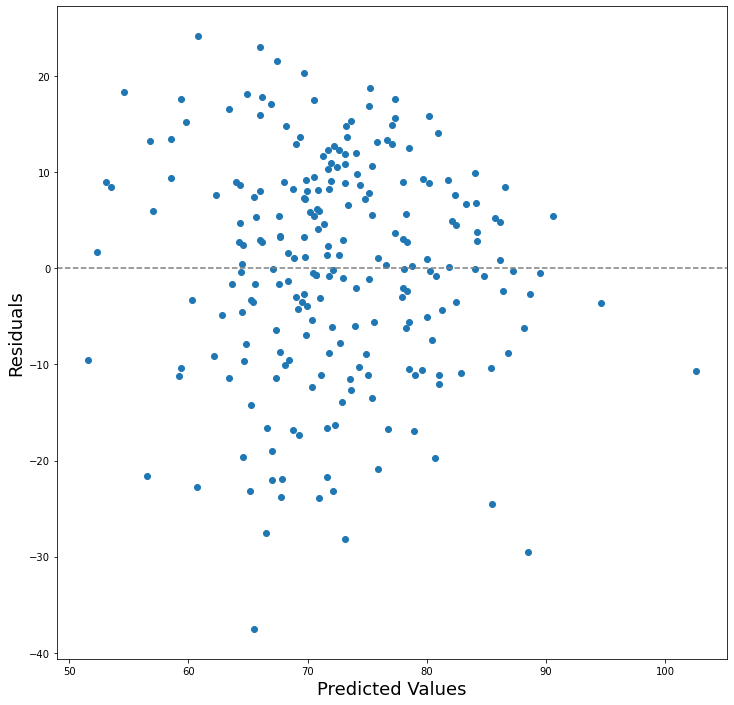

In [36]:
residuals = y_test - y_pred

plt.figure(figsize=(12,12))
plt.scatter(y_pred,residuals)

plt.axhline(0,linestyle="--",color='gray')
plt.xlabel('Predicted Values',fontsize=18)
plt.ylabel('Residuals',fontsize=18)

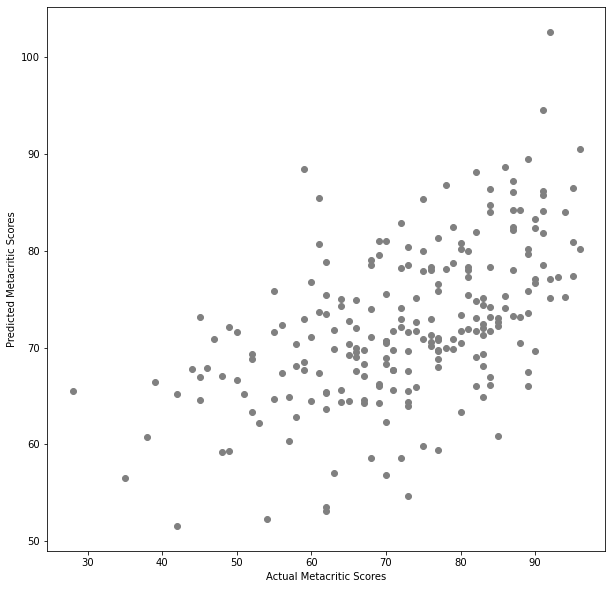

In [37]:
plt.figure(figsize=(10,10))

plt.scatter(y_test, y_pred, color='gray')

plt.xlabel("Actual Metacritic Scores")
plt.ylabel("Predicted Metacritic Scores");